In [ ]:
import glob
from google.colab import drive
import warnings
from datetime import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

In [ ]:
set_matplotlib_formats('retina')
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

indic = 'Température moyenne de surface'
saisons = ["Hiver","Printemps","Été","Automne"]

monthDictionary = {
    1:'Janvier',
    2:'Février',
    3:'Mars',
    4:'Avril',
    5:'Mai',
    6:'Juin',
    7:'Juillet',
    8:'Août',
    9:'Septembre',
    10:'Octobre',
    11:'Novembre',
    12:'Décembre'
}

In [ ]:
startYear = 1890
period = 10
titleSize = 30
axLabelSize = 20
tickLabelSize = 16

muted = sns.color_palette("muted", 10)
bright = sns.color_palette("bright", 10)
pastel = sns.color_palette("pastel", 10)
custom = [muted[9],muted[2],bright[8],bright[1]]
colorsPx = []
for color in custom:
    color = list(color)
    color = [int(255*subcolor) for subcolor in color]
    color = tuple(color)
    colorsPx.append(color)
        

colorsPx = {
    'Hiver': f'rgb{colorsPx[0]}',
    'Printemps': f'rgb{colorsPx[1]}',
    'Été': f'rgb{colorsPx[2]}',
    'Automne': f'rgb{colorsPx[3]}'
}

def newSns():
    plt.figure(figsize = (25,10))

def paramSnsPlot(plot,title,xlabel,ylabel):
  plot.set_title(title,fontsize = titleSize, y = 1.05)
  plot.set_xlabel(xlabel, fontsize = axLabelSize)
  plot.set_ylabel(ylabel, fontsize = axLabelSize)
  plt.xticks(fontsize = tickLabelSize)
  plt.yticks(fontsize = tickLabelSize)
  plot.xaxis.set_label_coords(0.5,-0.06)
  plot.yaxis.set_label_coords(-0.03,0.5)

def updateSnsLegend(plot):
  plt.setp(plot.get_legend().get_title(),
         fontsize= axLabelSize)
  plt.setp(plot.get_legend().get_texts(),
         fontsize= tickLabelSize)

def paramsPxPlot(plot,title,xlabel,ylabel):
    fig.update_layout(
        title = {
            'text': title,
            'x': 0.5
        },
        xaxis_title = xlabel,
        yaxis_title = ylabel
    )



In [ ]:
# PRÉPARATION DES DONNÉES
drive.mount('/content/drive')
source = "/content/drive/My Drive/PROJECT 2/"
file = "GlobalTemperatures.csv"
dataset = pd.read_csv(source + file,sep=',')

dataset['dt'] = pd.to_datetime(dataset['dt'])
dataset = dataset[['dt','LandAverageTemperature','LandAverageTemperatureUncertainty']]
dataset = dataset.rename(columns = {'dt':'Date','LandAverageTemperature': indic,'LandAverageTemperatureUncertainty': 'Incertitude'})
dataset['N° Mois'] = dataset['Date'].dt.month
dataset['Mois'] = [monthDictionary[mois] for mois in dataset['N° Mois']]
dataset['Année'] = dataset['Date'].dt.year
dataset['Décennie'] = dataset['Date'].dt.year//10*10
dataset['Saison'] = ["Hiver" if month%12 <= 2 else \
                     "Printemps" if month%12 <= 5 else \
                     "Été" if month%12 <= 8 else \
                     "Automne" for month in dataset['N° Mois']]

dataset

Mounted at /content/drive


,Date,Température moyenne de surface,Incertitude,N° Mois,Mois,Année,Décennie,Saison
0,1750-01-01,3.034,3.574,1,Janvier,1750,1750,Hiver
1,1750-02-01,3.083,3.702,2,Février,1750,1750,Hiver
2,1750-03-01,5.626,3.076,3,Mars,1750,1750,Printemps
3,1750-04-01,8.490,2.451,4,Avril,1750,1750,Printemps
4,1750-05-01,11.573,2.072,5,Mai,1750,1750,Printemps
...,...,...,...,...,...,...,...,...
3187,2015-08-01,14.755,0.072,8,Août,2015,2010,Été
3188,2015-09-01,12.999,0.079,9,Septembre,2015,2010,Automne
3189,2015-10-01,10.801,0.102,10,Octobre,2015,2010,Automne
3190,2015-11-01,7.433,0.119,11,Novembre,2015,2010,Automne


In [ ]:
# DÉTECTION DES OUTLIERS PAR LA MÉTHODE 1,5 x L'ÉCART INTERQUARTILES

dataset['Q1'] = [dataset[dataset['N° Mois'] == month][indic].quantile(0.25) for month in dataset['N° Mois']]
dataset['Q3'] = [dataset[dataset['N° Mois'] == month][indic].quantile(0.75) for month in dataset['N° Mois']]
dataset['InfOutlier'] = dataset['Q1'] - 1.5*(dataset['Q3'] - dataset['Q1'])
dataset['SupOutlier'] = dataset['Q3'] + 1.5*(dataset['Q3'] - dataset['Q1'])
dataset['Outliers'] = ['Donnée aberrante'\
                      if (row[indic] <= row['InfOutlier']) or (row[indic] >= row['SupOutlier'])\
                      else 'Donnée valide'\
                      for index, row in dataset.iterrows()]

In [ ]:
# AFFICHAGE DES OUTLIERS
min = dataset[indic].min()
max = dataset[indic].max()
title = {
    'title_text': "Mise en évidence des températures aberrantes entre 1750 et 2015, par mois",
    'title_x': 0.2
}
labels = {
    'LandAverageTemperature': "Température globale de surface (°C)"
}

fig = px.scatter(data_frame = dataset,
                 x = 'Date',
                 y = indic,
                 color = 'Outliers',
                 animation_frame = 'Mois',
                 labels = labels)

fig.update_layout(title,labels)
fig.update_yaxes(range = [min,max])
fig.show()

La mise en évidence des outliers permet de discriminer certaines données. Cependant, certaines données valides présentent malgré tout une dispersion importante et inégale selon les années. La visualisation de l'incertitude de la mesure, en °C, donnée présente dans le dataset, permet de mieux séléctionner l'année seuil à partir de laquelle les donnée peuvent réellement être considérées comme valides.

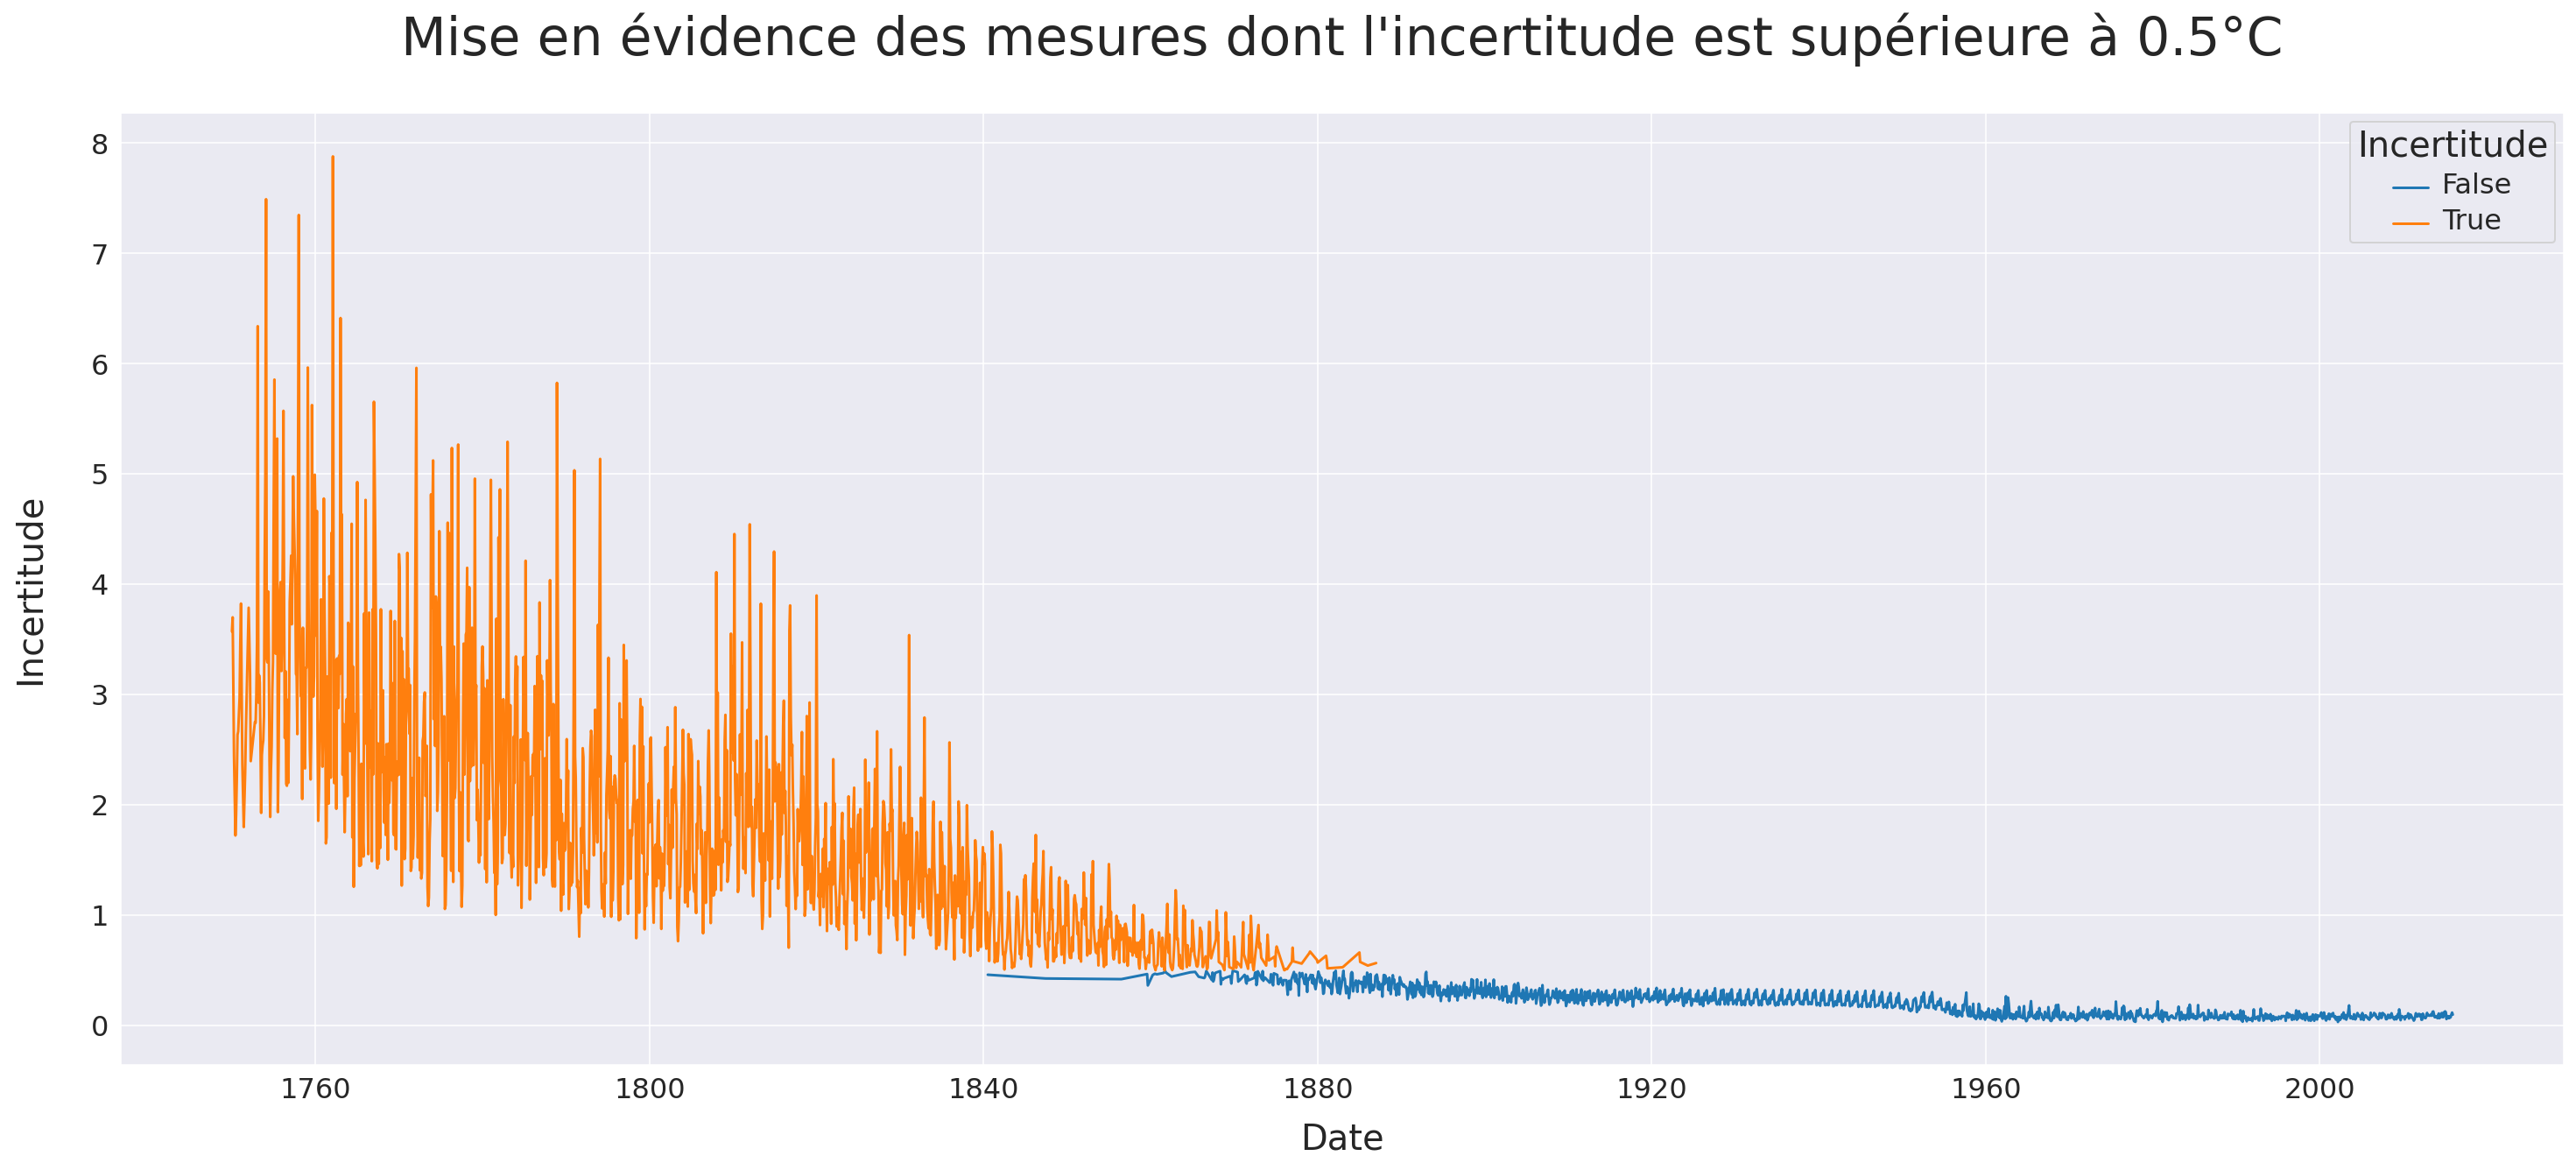

In [ ]:
seuil = 0.5
newSns()
fig = sns.lineplot(data = dataset,
                   x = 'Date',
                   y = 'Incertitude',
                   hue = dataset['Incertitude'] > seuil)
paramSnsPlot(fig,f"Mise en évidence des mesures dont l'incertitude est supérieure à {seuil}°C","Date","Incertitude")
updateSnsLegend(fig)
plt.show()

Le seuil arbitraire d'une incertitude de 0,5°C nous permet de séléctionner les données à partir de 1990 pour le modèle de régression et les visualisations d'augmentation

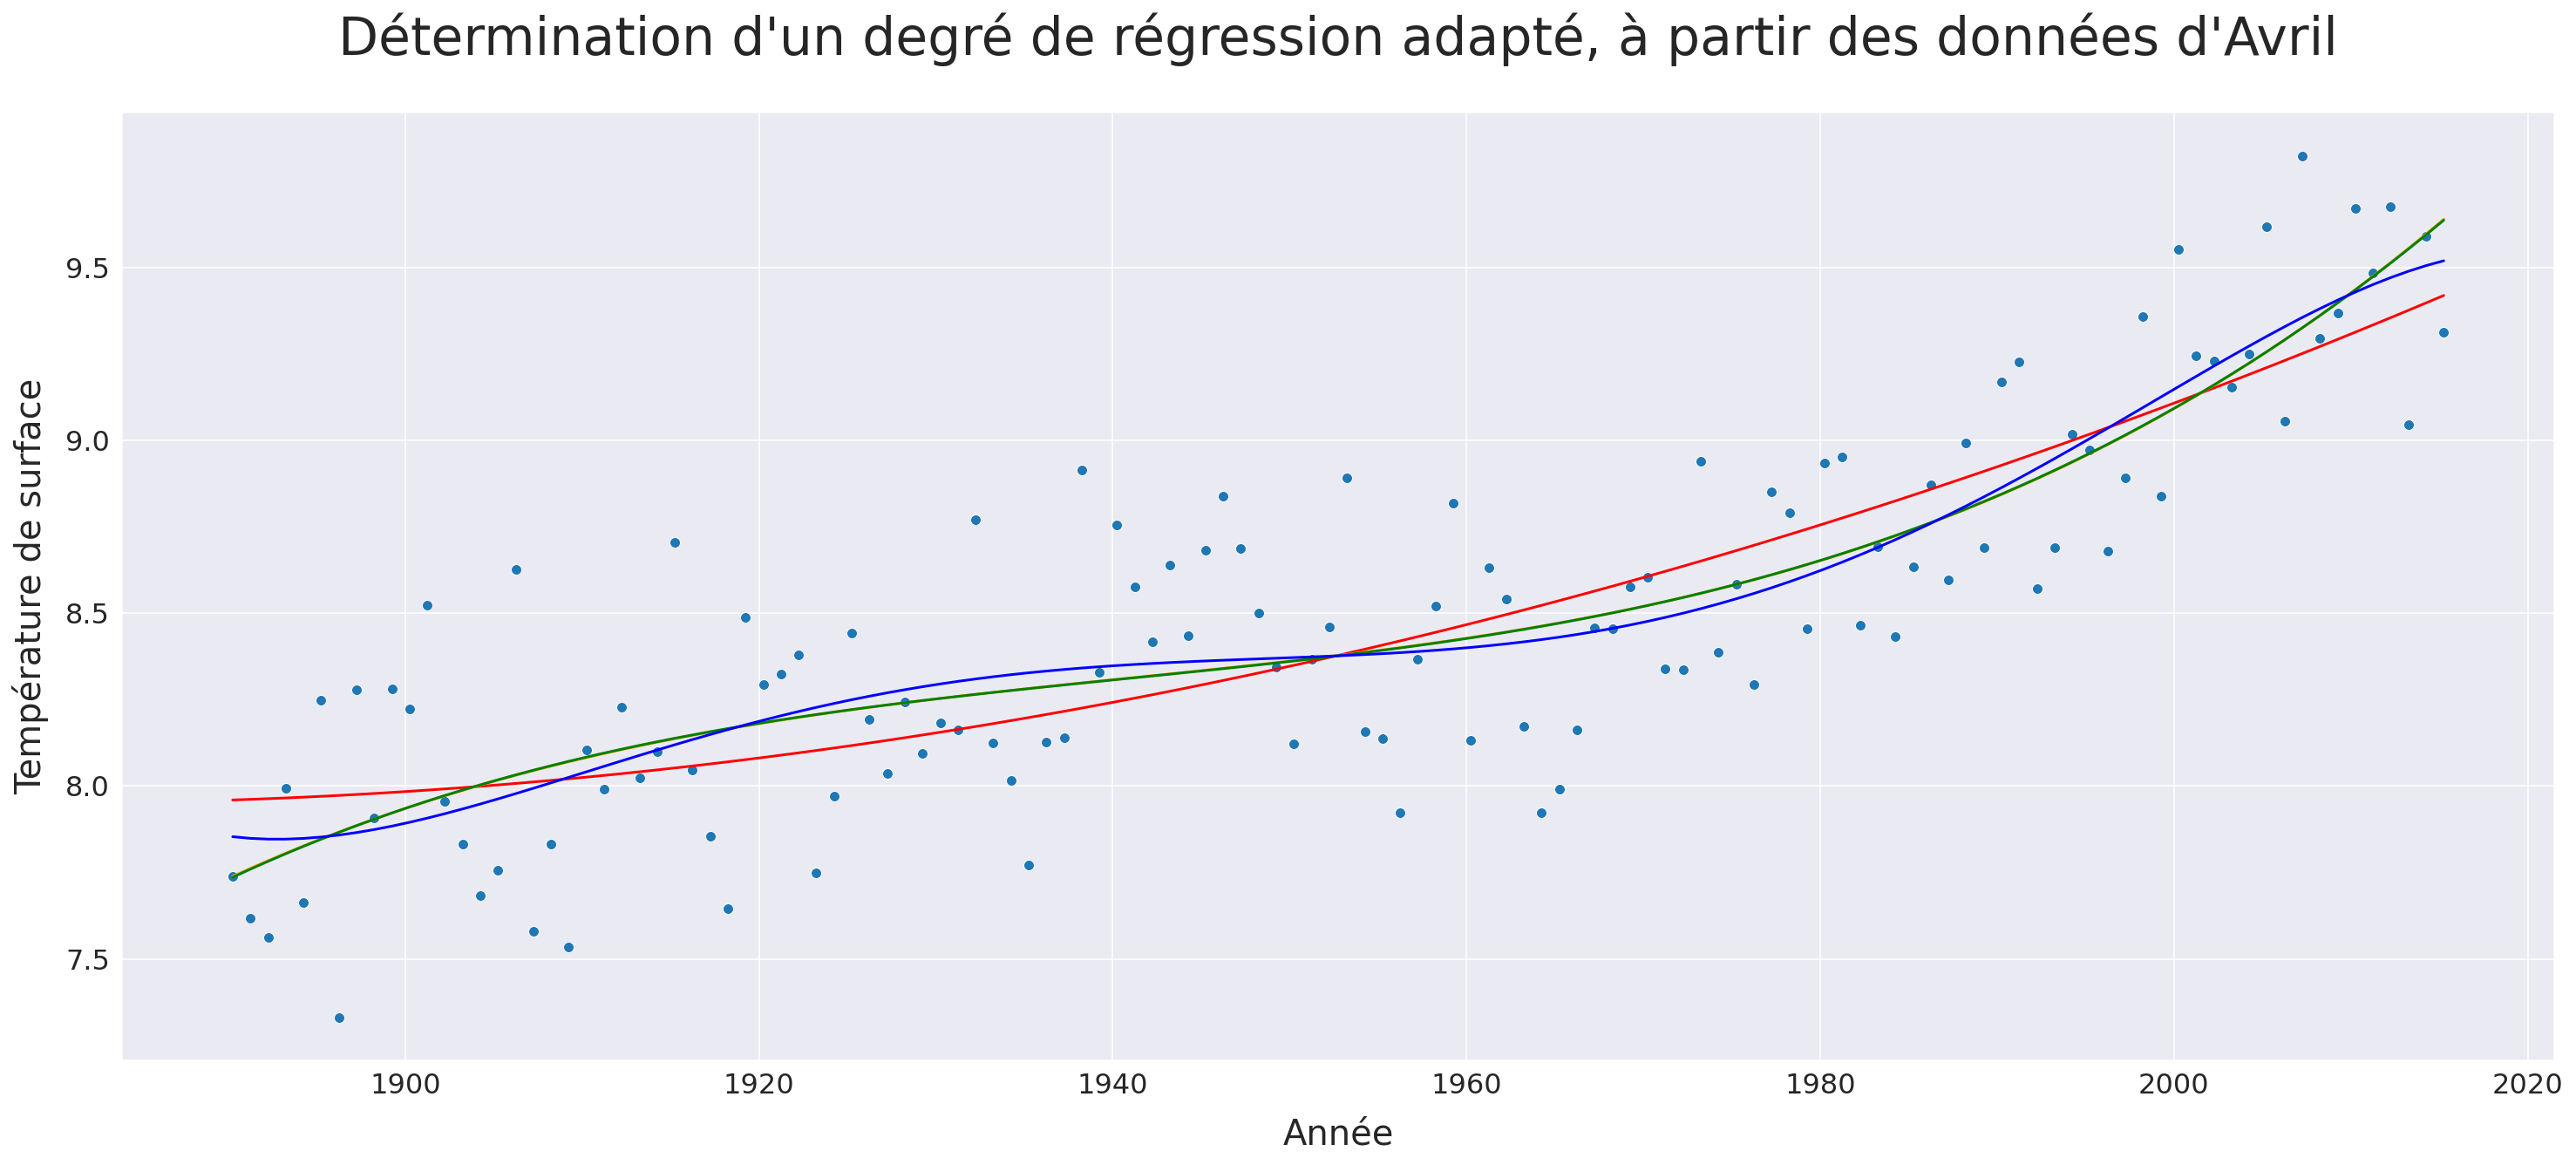

In [ ]:
# DÉTERMINATION DU DEGRÉ DE RÉGRESSION ADAPTÉ

monthData = dataset[(dataset['Année'] >= startYear) & (dataset['N° Mois'] == 4)]
Xaxis = monthData['Année']
Yaxis = monthData[indic]
colorList = ['red','orange','green','blue']
degList = [2,3,4,5]

newSns()
scatter = sns.scatterplot(data = monthData,
                              x = 'Date',
                              y = indic)
for deg in degList:
    model = np.polyfit(x = Xaxis,y = Yaxis, deg = deg)
    scatter = sns.lineplot(x = monthData['Date'],
                          y = np.poly1d(model)(monthData['Année']),
                          color = colorList[degList.index(deg)])

    # On privilégie le degré 3 pour éviter l'overfitting
    if deg == 3:
      polymodel = model

paramSnsPlot(scatter,"Détermination d'un degré de régression adapté, à partir des données d'Avril",'Année','Température de surface')

plt.show()

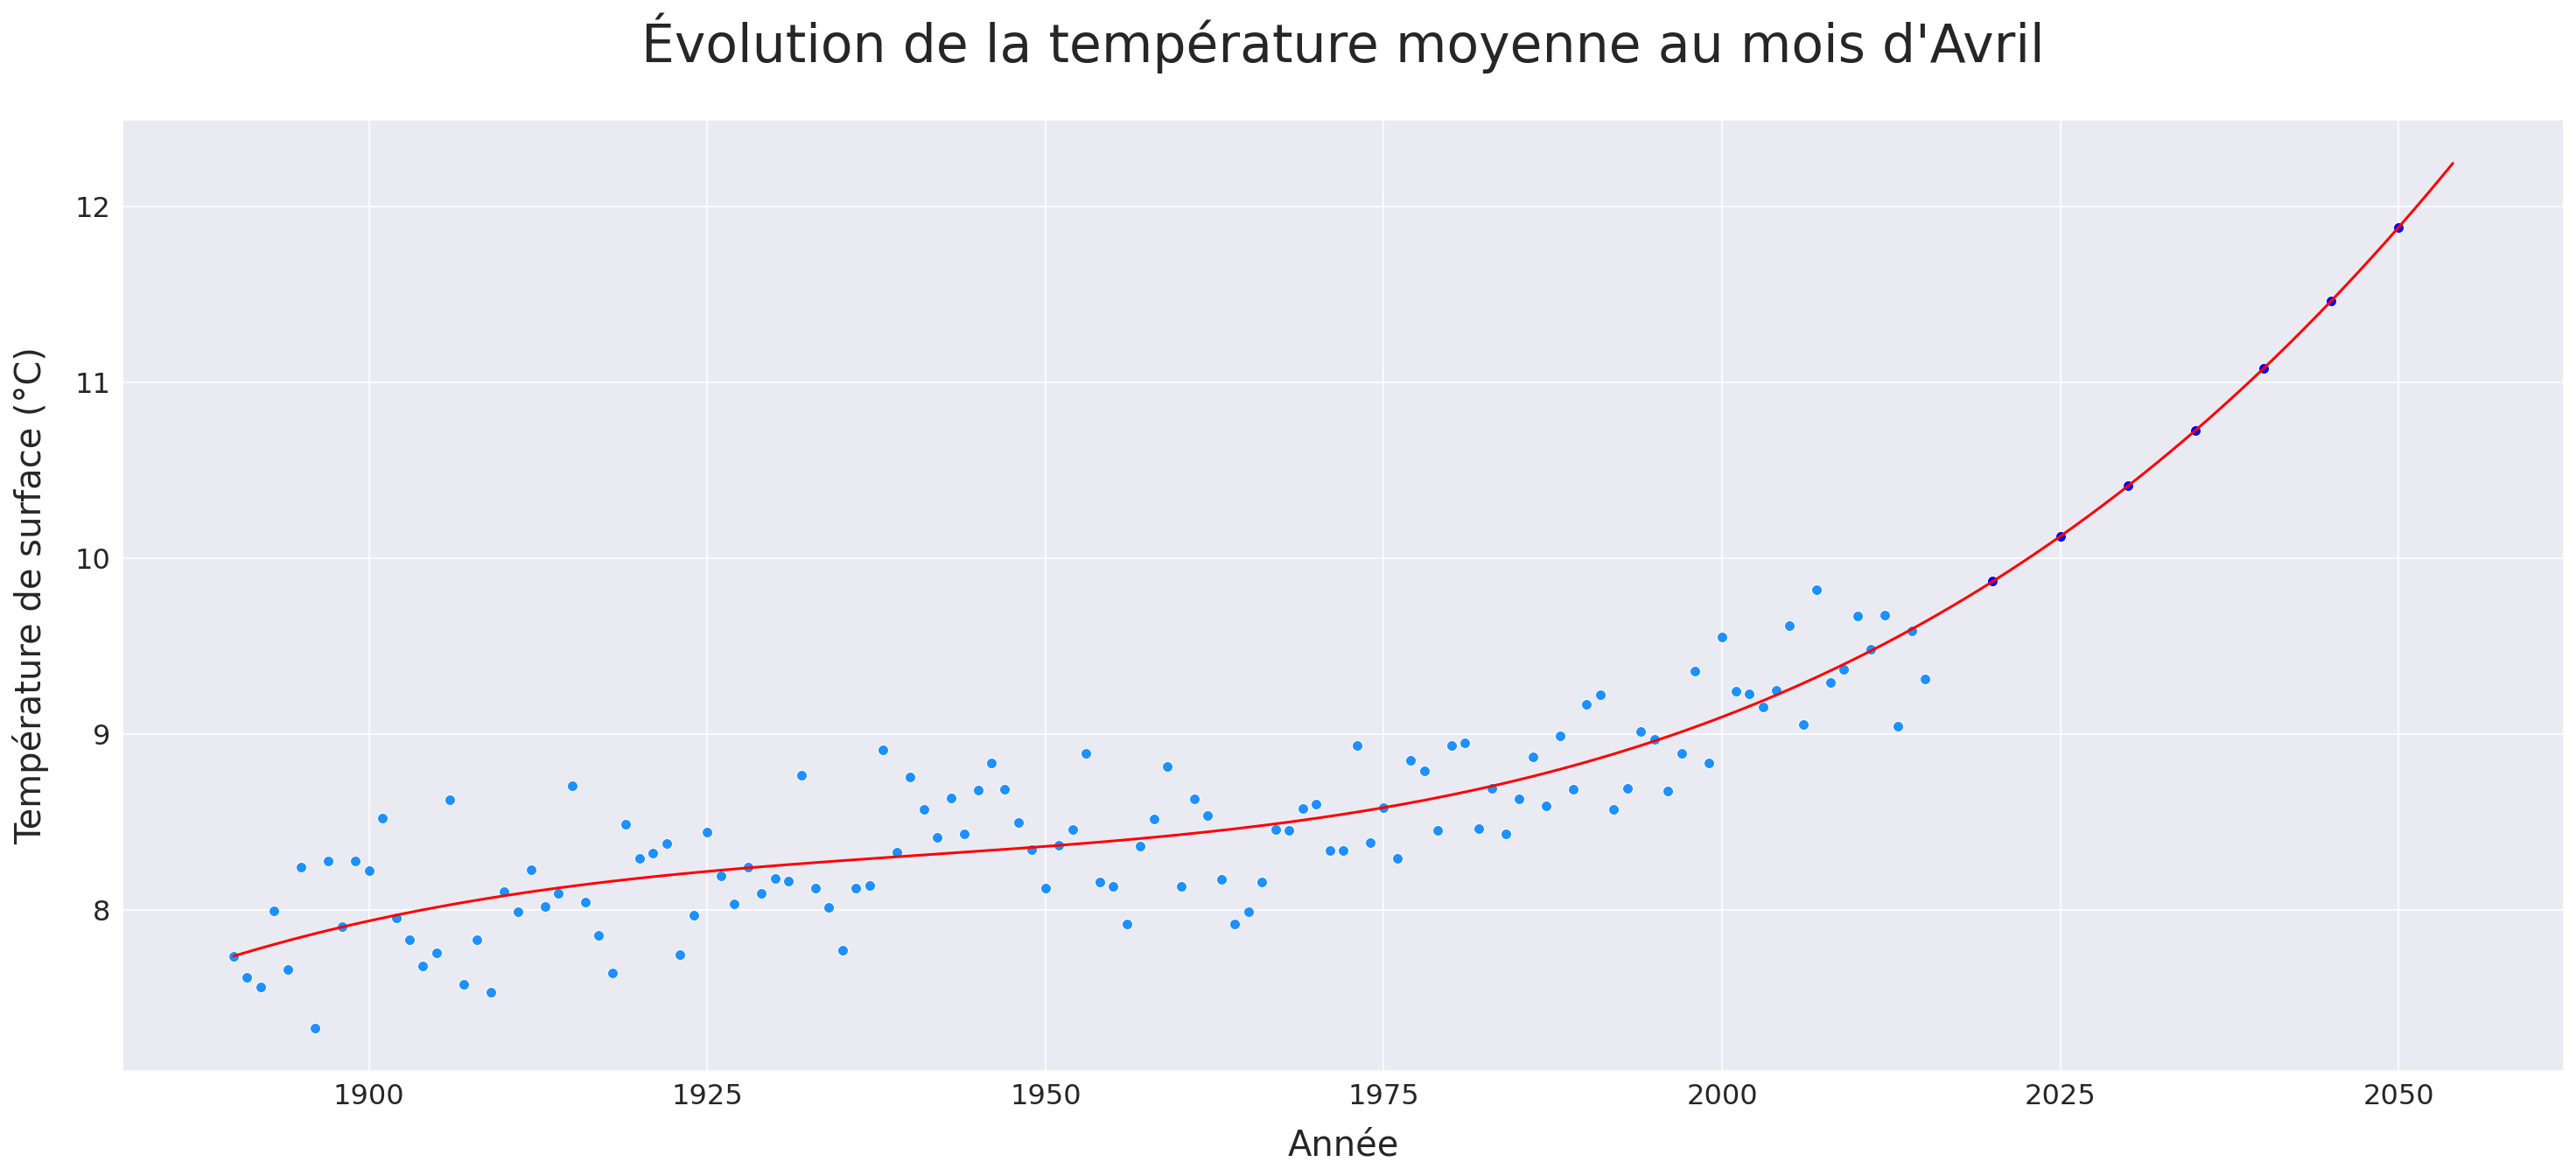

In [ ]:
# AFFICHAGE DU DEGRÉ DE RÉGRESSION ADAPTÉ

newSns()
plt.title("Evolution de la température moyenne de surface")
scatter = sns.scatterplot(data = monthData,
                              x = 'Année',
                              y = indic,
                          color = 'dodgerblue')
scatter = sns.lineplot(x = list(range(1890,2055)),
                        y = np.poly1d(polymodel)(list(range(1890,2055))),
                        color = 'red')
scatter = sns.scatterplot(x = list(range(2020,2051,5)),
                              y = np.poly1d(polymodel)(list(range(2020,2051,5))),
                          color = 'blue')
paramSnsPlot(scatter,"Évolution de la température moyenne au mois d'Avril","Année","Température de surface (°C)")

plt.show()

In [ ]:
# PRÉDICTIONS

r2 = r2_score(list(monthData[indic]), np.poly1d(polymodel)(monthData['Année']))
print(f'Coefficient de détermination R² du modèle : {round(r2,3)}')
print('Prédiction de températures de surface moyenne en Avril :')
for year in range(2020,2055,5):
    print(f'Année {year} : {round(np.poly1d(polymodel)(year),1)}°C') 

Coefficient de détermination R² du modèle : 0.714
Prédiction de températures de surface moyenne en Avril :
Année 2020 : 9.9°C
Année 2025 : 10.1°C
Année 2030 : 10.4°C
Année 2035 : 10.7°C
Année 2040 : 11.1°C
Année 2045 : 11.5°C
Année 2050 : 11.9°C


In [ ]:
# RÉGRESSION POLYNOMIALE
regData = dataset[(dataset['Année'] >= startYear)]

# CALCUL D'UN POLYMODEL PAR MOIS
polymodel = [np.polyfit(x = regData[dataset['Mois'] == month]['Année'],
                       y = regData[dataset['Mois'] == month][indic],
                       deg = 3) for month in regData['Mois'].unique()]

# INTÉGRATION AU DATAFRAME
regressionSeries = []  
for index, row in regData.iterrows():
    month = row['N° Mois']
    year = row['Année']
    regressionSeries.append(np.poly1d(polymodel[month-1])(year))
regData['Régression'] = regressionSeries

In [ ]:
decData = regData
decData = decData[['N° Mois','Mois','Saison','Décennie',indic]].groupby(['N° Mois','Mois','Saison','Décennie']).mean().reset_index().sort_values(by = ['Décennie','N° Mois'])

augmentationSeries = []
for index, row in decData.iterrows():
    augmentationSeries.append(row[indic] - decData[(decData['Mois'] == row['Mois']) & (decData['Décennie'] == startYear//10*10)][indic].values[0])
decData['Augmentation'] = augmentationSeries

max = decData['Augmentation'].max()
min = decData['Augmentation'].min()

fig = px.bar(
    data_frame = decData.sort_values(['Décennie','N° Mois','Mois']),
    x = 'Mois',
    y = 'Augmentation',
    color = 'Saison',
    color_discrete_map = colorsPx,
    animation_frame = 'Décennie',
    category_orders = {'Mois': list(decData['Mois'].unique())})
paramsPxPlot(fig,f"Augmentation de température par saison","Mois","Augmentation (°C)")

fig.update_yaxes(range = [min-0.2,max+0.2])

fig.show()

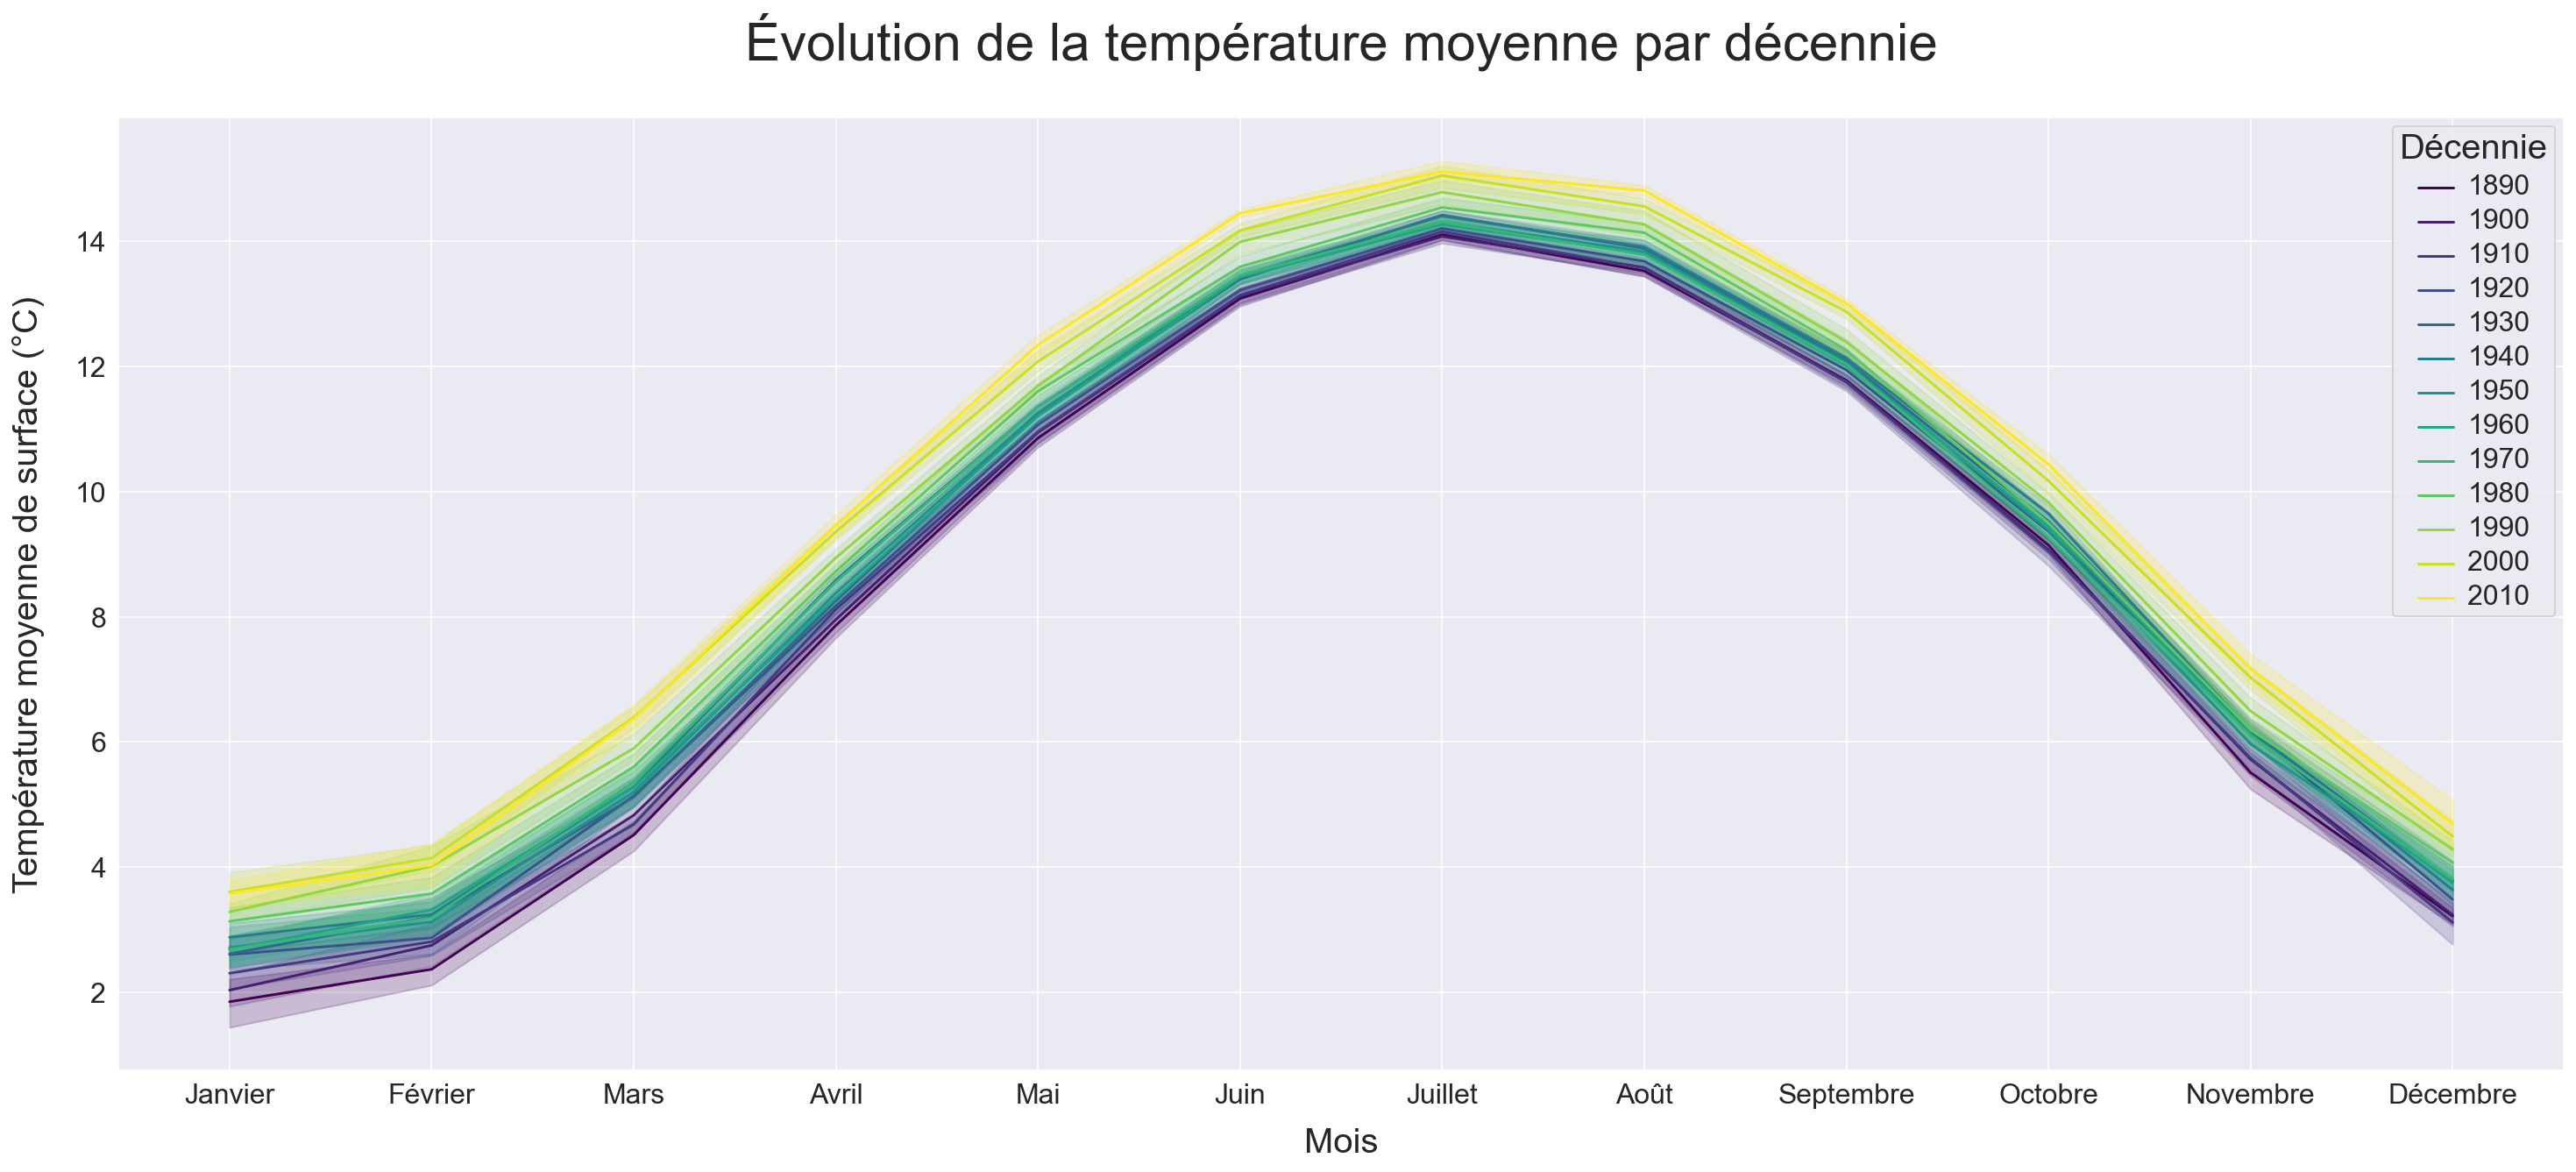

In [ ]:
augmentationSeries = []
for index, row in regData.iterrows():
  augmentationSeries.append(row[indic] - regData[(regData['Mois'] == row['Mois']) & (regData['Année'] == startYear)][indic].values[0])
regData['Augmentation'] = augmentationSeries
max = regData[indic].max()
min = regData[indic].min()

newSns()
fig = sns.lineplot(
    data = regData,
    x = 'Mois',
    y = indic,
    hue = 'Décennie',
    palette = sns.color_palette("viridis", as_cmap=True),
    legend = 'full')
paramSnsPlot(fig,'Évolution de la température moyenne par décennie','Mois','Température moyenne de surface (°C)')
updateSnsLegend(fig)
plt.show()